In [32]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import json
from cartopy import crs as ccrs
import matplotlib.ticker as mticker
from torchmetrics.regression import MeanAbsolutePercentageError

In [ ]:
# NGCD DATA
INPUT_PATH_NGCD = ... # can be created with data_processing/save_nordic_lr-hr_data.py
TARGET_PATH_NGCD = ... # can be created with data_processing/save_nordic_lr-hr_data.py

PRED_PATH1_PATCH = ... # model output patches
PRED_PATH2_PATCH = ... # model output patches

In [34]:
pred_time_10 = torch.load(PRED_PATH1_PATCH)
pred_time_5 = torch.load(PRED_PATH2_PATCH)

In [35]:
input_ngcd = np.load(INPUT_PATH_NGCD)
target_ngcd = np.load(TARGET_PATH_NGCD)

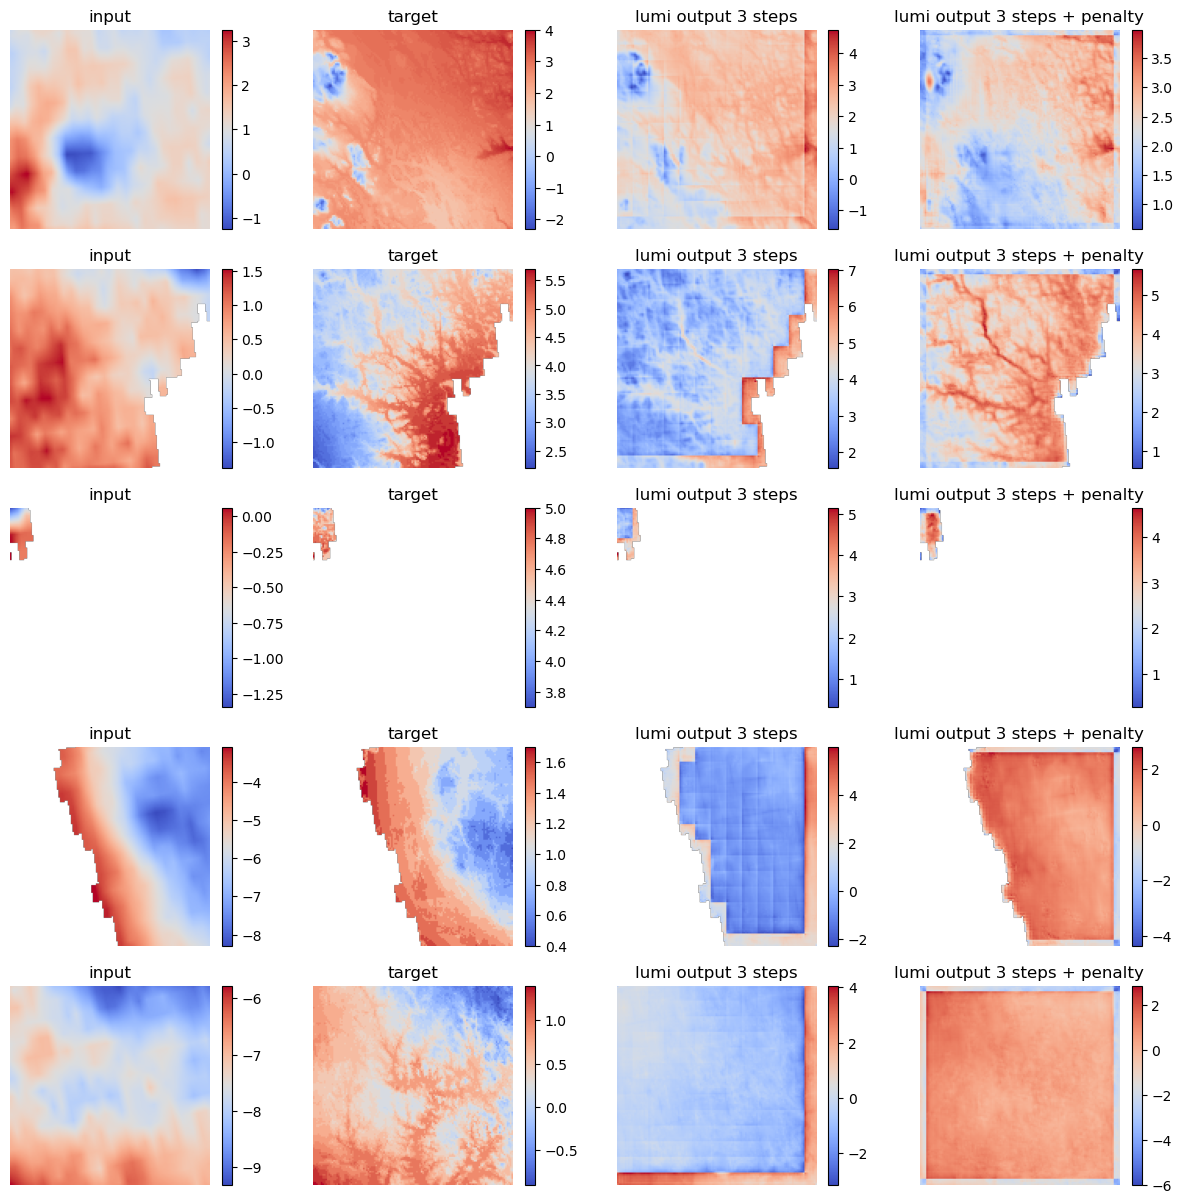

In [36]:
N = 5
n_cols = 4
pad = 1000
plt.subplots(N, n_cols, figsize=(15,15))

row = 0
for i in range(N):

    input_img = input_ngcd[i+pad + 2*117, 0, :]
    target_img = target_ngcd[i+pad + 2*117, 0, :]
    pred_img10 = pred_time_10[i+pad, 0, :]
    pred_img5 = pred_time_5[i+pad, 0, :]
    pred_img_masked10 = pred_img10.clone()
    pred_img_masked5 = pred_img5.clone()
    pred_img_masked10[np.isnan(input_img)] = float("nan")
    pred_img_masked5[np.isnan(input_img)] = float("nan")


    plt.subplot(N,n_cols,(row*n_cols)+1)
    plt.imshow(input_img, cmap="coolwarm")
    plt.axis('off')
    plt.title("input")
    plt.colorbar()

    plt.subplot(N,n_cols,(row*n_cols)+2)
    plt.imshow(target_img, cmap="coolwarm")
    plt.title("target")
    plt.axis('off')
    plt.colorbar()
    
    plt.subplot(N,n_cols,(row*n_cols)+3)
    plt.imshow(pred_img_masked10, cmap="coolwarm")
    plt.title("lumi output 3 steps")
    plt.axis('off')
    plt.colorbar()

    plt.subplot(N,n_cols,(row*n_cols)+4)
    plt.imshow(pred_img_masked5, cmap="coolwarm")
    plt.title("lumi output 3 steps + penalty")
    plt.axis('off')
    plt.colorbar()

    row += 1

plt.show()

In [37]:
# patch funcitions
PATCH = 128
STRIDE = 120

def fill_nans(patches, num_patches, image_shape, idx_kept, patch_size=PATCH):
    _, C, _, _ = image_shape
    nH, nW = num_patches
    tot_num_patches = nH * nW
    full_patches = torch.zeros([tot_num_patches, C, patch_size, patch_size]).type_as(patches)
    full_patches[:] = float("nan")
    full_patches[idx_kept, :] = patches

    return full_patches

def combine_patches(patches, num_patches, img_shape, idx_kept, patch_size=PATCH, stride=STRIDE):
    """
    Combine overlapping patches back into full images using mean overlap.

    Args:
        patches: tensor (B * n_patches, C, patch_size, patch_size)
        num_patches: tulpe (nH, nW)
        img_shape: tuple (B, C, H, W)
        patch_size: int
        stride: int

    Returns:
        Reconstructed full-size image tensor (B, C, H, W)
    """
    
    patches = fill_nans(patches, num_patches, img_shape, idx_kept)

    B, C, H, W = img_shape
    nH, nW = num_patches

    device = patches.device
    output = torch.zeros((B, C, H, W), device=device)
    norm_map = torch.zeros_like(output)

    patch_idx = 0
    for b in range(B):
        for i in range(nH):
            for j in range(nW):
                h_start = i * stride
                w_start = j * stride
                h_end = h_start + patch_size
                w_end = w_start + patch_size

                output[b, :, h_start:h_end, w_start:w_end] += patches[patch_idx]
                norm_map[b, :, h_start:h_end, w_start:w_end] += 1
                patch_idx += 1

    return (output / norm_map)

In [ ]:
DAY_PTR_PATH = ... # can be created with data_processing/save_nordic_lr-hr_data.py
IDX_KEEP_PATH = ... # can be created with data_processing/save_nordic_lr-hr_data.py
META_PATH = ... # can be created with data_processing/save_nordic_lr-hr_data.py
DATES_PATH = ... # can be created with data_processing/save_nordic_lr-hr_data.py
MASK_FILE_PATH = ... # can be created with data_processing/save_nordic_lr-hr_data.py
COORDS_PATH = "coords.npz" # NGCD coordinates for plotting

ngcd_sample = 5

In [39]:
day_ptr = np.load(DAY_PTR_PATH)
idx_keep = np.load(IDX_KEEP_PATH)

with open(META_PATH) as f: test_meta = json.load(f)
with open(DATES_PATH) as f: test_dates = json.load(f)

In [40]:
daily_eobs = []
daily_ngcd = []
daily_pred_5 = []
daily_pred_10 = []
daily_idx_keep = []

for i in range(len(day_ptr)-1-2):
    start_pred, end_pred = day_ptr[i], day_ptr[i+1]
    start_io, end_io = day_ptr[i+2], day_ptr[i+1+2]
    daily_eobs.append(torch.tensor(input_ngcd[start_io:end_io, :]))
    daily_ngcd.append(torch.tensor(target_ngcd[start_io:end_io, :]))
    daily_pred_5.append(pred_time_5[start_pred:end_pred, :])
    daily_pred_10.append(pred_time_10[start_pred:end_pred, :])
    daily_idx_keep.append(idx_keep[start_pred:end_pred])

In [41]:
eobs_recon_test = combine_patches(patches=daily_eobs[ngcd_sample], 
                                  num_patches=test_meta["num_patches"], 
                                  img_shape=test_meta["padded_shape"], 
                                  idx_kept=daily_idx_keep[ngcd_sample])

In [42]:
ngcd_recon_test = combine_patches(patches=daily_ngcd[ngcd_sample], 
                                  num_patches=test_meta["num_patches"], 
                                  img_shape=test_meta["padded_shape"], 
                                  idx_kept=daily_idx_keep[ngcd_sample])

In [43]:
pred_10_recon_test = combine_patches(patches=daily_pred_10[ngcd_sample], 
                                    num_patches=test_meta["num_patches"], 
                                    img_shape=test_meta["padded_shape"], 
                                    idx_kept=daily_idx_keep[ngcd_sample])

In [44]:
pred_5_recon_test = combine_patches(patches=daily_pred_5[ngcd_sample], 
                                    num_patches=test_meta["num_patches"], 
                                    img_shape=test_meta["padded_shape"], 
                                    idx_kept=daily_idx_keep[ngcd_sample])

In [45]:
# mask 
mask_out = np.load(MASK_FILE_PATH)
row_mask = mask_out["row"]
col_mask = mask_out["col"]
nan_mask = mask_out["nan"]

In [46]:
ngcd_recon_cropped = ngcd_recon_test[:, :, :nan_mask.shape[0], :nan_mask.shape[1]]
eobs_recon_cropped = eobs_recon_test[:, :, :nan_mask.shape[0], :nan_mask.shape[1]]

In [47]:
pred_10_recon_cropped = pred_10_recon_test[:, :, :nan_mask.shape[0], :nan_mask.shape[1]]
pred_10_recon_masked = pred_10_recon_cropped.clone()
pred_10_recon_masked[0, 0, nan_mask] = float("nan")

pred_5_recon_cropped = pred_5_recon_test[:, :, :nan_mask.shape[0], :nan_mask.shape[1]]
pred_5_recon_masked = pred_5_recon_cropped.clone()
pred_5_recon_masked[0, 0, nan_mask] = float("nan")

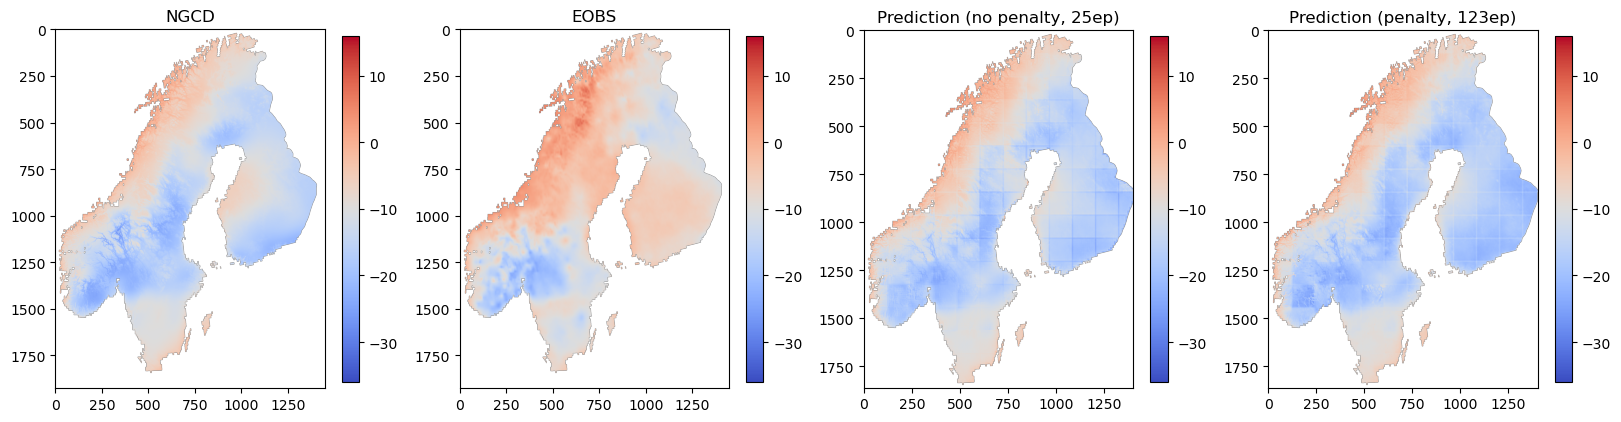

In [48]:
plt.subplots(1,4, figsize=(20,15))
shrink = 0.3

col_range = (-36, 16)
norm_colors = matplotlib.colors.Normalize(vmin=col_range[0], vmax=col_range[1])

plt.subplot(141)
plt.imshow(ngcd_recon_test[0,0,...], cmap="coolwarm", norm=norm_colors)
plt.title("NGCD")
plt.colorbar(shrink=shrink)

plt.subplot(142)
plt.imshow(eobs_recon_test[0,0,...], cmap="coolwarm", norm=norm_colors)
plt.title("EOBS")
plt.colorbar(shrink=shrink)

plt.subplot(143)
plt.imshow(pred_10_recon_masked[0,0,...], cmap="coolwarm", norm=norm_colors)
plt.title("Prediction (no penalty, 25ep)")
plt.colorbar(shrink=shrink)

plt.subplot(144)
plt.imshow(pred_5_recon_masked[0,0,...], cmap="coolwarm", norm=norm_colors)
plt.title("Prediction (penalty, 123ep)")
plt.colorbar(shrink=shrink)

plt.show()

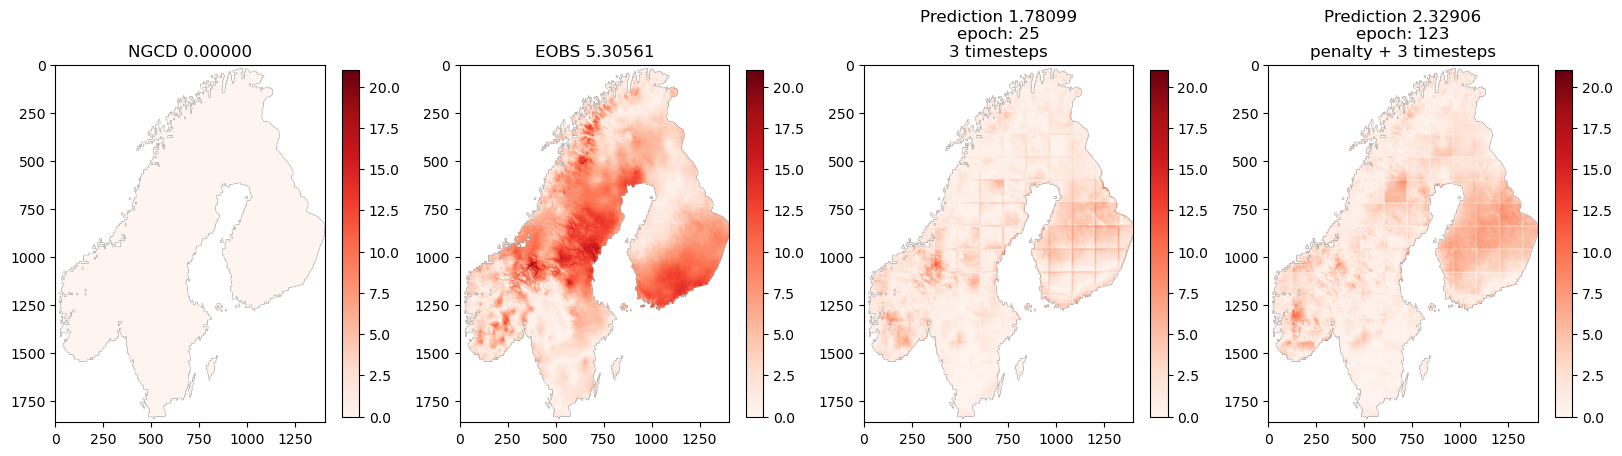

In [49]:
norm_colors = matplotlib.colors.Normalize(0,21)

plt.subplots(1,4, figsize=(20,15))
shrink = 0.3

plt.subplot(141)
err = abs(ngcd_recon_test[0,0,:1863,:1404]-ngcd_recon_test[0,0,:1863,:1404])
mae = torch.nanmean(err).item()
plt.imshow(err, cmap="Reds", norm=norm_colors)
plt.title(f"NGCD {mae:.5f}")
plt.colorbar(shrink=shrink)

plt.subplot(142)
err = abs(eobs_recon_test[0,0,:1863,:1404]-ngcd_recon_test[0,0,:1863,:1404])
mae = torch.nanmean(err).item()
plt.imshow(err, cmap="Reds", norm=norm_colors)
plt.title(f"EOBS {mae:.5f}")
plt.colorbar(shrink=shrink)


plt.subplot(143)
err = abs(pred_10_recon_masked[0,0,...]-ngcd_recon_test[0,0,:1863,:1404])
mae = torch.nanmean(err).item()
plt.imshow(err, cmap="Reds", norm=norm_colors)
plt.title(f"Prediction {mae:.5f}\nepoch: 25\n3 timesteps")
plt.colorbar(shrink=shrink)

plt.subplot(144)
err = abs(pred_5_recon_masked[0,0,...]-ngcd_recon_test[0,0,:1863,:1404])
mae = torch.nanmean(err).item()
plt.imshow(err, cmap="Reds", norm=norm_colors)
plt.title(f"Prediction {mae:.5f}\nepoch: 123\npenalty + 3 timesteps")
plt.colorbar(shrink=shrink)

plt.show()

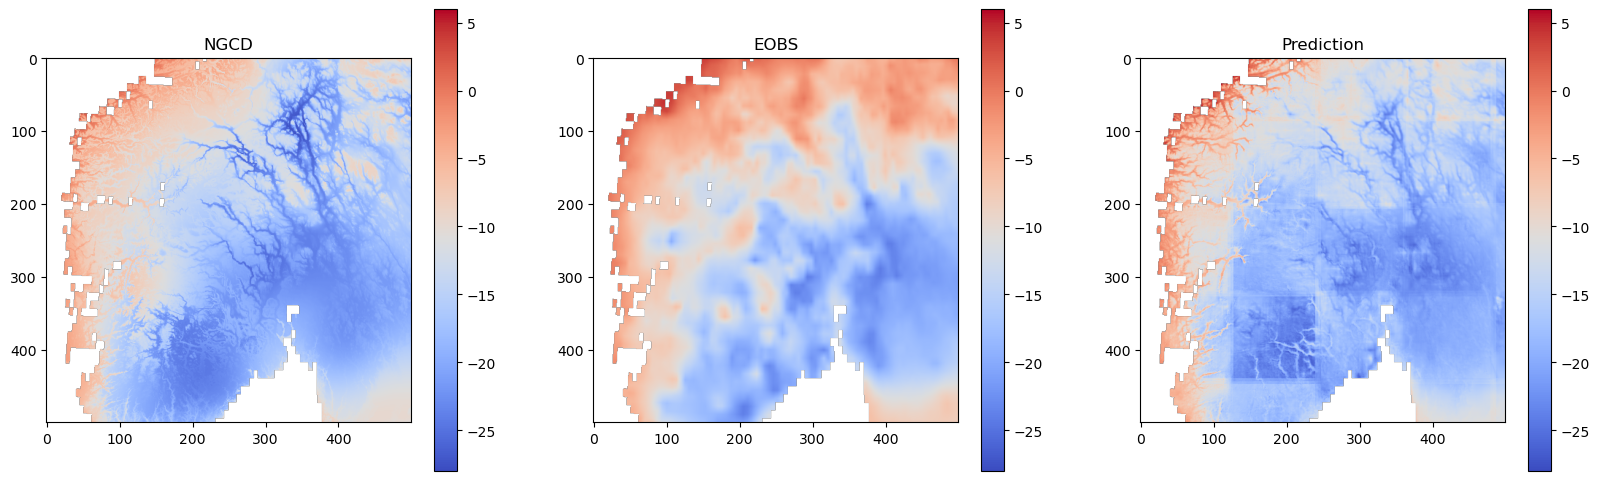

In [50]:
plt.subplots(1,3, figsize=(20,15))
shrink = 0.4

col_range = (-28, 6)
    
norm_colors = matplotlib.colors.Normalize(vmin=col_range[0], vmax=col_range[1])

plt.subplot(131)
plt.imshow(ngcd_recon_test[0,0,1000:1500,0:500], cmap="coolwarm", norm=norm_colors)
plt.title("NGCD")
plt.colorbar(shrink=shrink)

plt.subplot(132)
plt.imshow(eobs_recon_test[0,0,1000:1500,0:500], cmap="coolwarm", norm=norm_colors)
plt.title("EOBS")
plt.colorbar(shrink=shrink)

plt.subplot(133)
plt.imshow(pred_5_recon_masked[0,0,1000:1500,0:500], cmap="coolwarm", norm=norm_colors)
plt.title("Prediction")
plt.colorbar(shrink=shrink)

plt.show()

In [51]:
coords = np.load(COORDS_PATH)

In [52]:
X = coords["X"]
Y = coords["Y"]

In [53]:
err_ngcd = (pred_5_recon_masked[0,0,...]-ngcd_recon_test[0,0,:1863,:1404])
abs_err_ngcd = abs(err_ngcd)

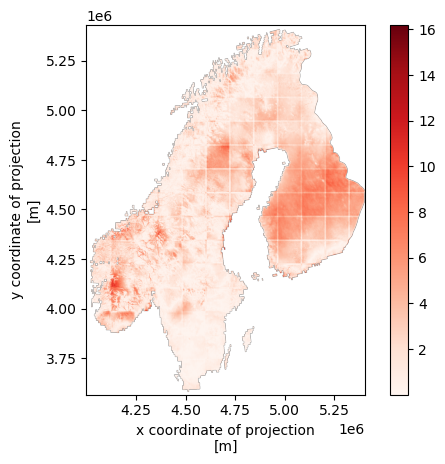

In [54]:
plt.figure()

extent = [X.min(), X.max(), Y.min(), Y.max()]

plt.imshow(
    abs_err_ngcd,
    extent=extent,
    origin="upper",
    cmap="Reds",
)

plt.xlabel("x coordinate of projection\n[m]")
plt.ylabel("y coordinate of projection\n[m]")
plt.colorbar()
plt.show()

In [55]:
# Metrics (for a single sample)
target = ngcd_recon_test[0,0,:1863,:1404]
pred = pred_5_recon_masked[0,0,...]

In [56]:
mae = torch.nanmean(abs(target-pred)).item()

In [57]:
mse = torch.nanmean(torch.sqrt(target-pred)).item()

In [58]:
target_flat = target.flatten()
pred_flat = pred.flatten()

mask = torch.isfinite(target_flat) & torch.isfinite(pred_flat)

R2 = np.corrcoef(target_flat[mask], pred_flat[mask])[0,1] ** 2

In [59]:
mape_fun = MeanAbsolutePercentageError()

In [60]:
mape = mape_fun(target_flat[mask], pred_flat[mask]).item()

In [61]:
target_flat = target.flatten()
pred_flat = pred.flatten()

mask = torch.isfinite(target_flat) & torch.isfinite(pred_flat)

R2 = np.corrcoef(target_flat[mask], pred_flat[mask])[0,1] ** 2

In [62]:
print("mae",mae, "mse", mse, "mape", mape, "R2", R2)

mae 2.3290646076202393 mse 1.5184335708618164 mape 0.3701786398887634 R2 0.7977614076008497


In [ ]:
# ERA5 DATA
PRED_PATH_ERA = ... # model about
INPUT_PATH_ERA = ... # available in Google Drive
TARGET_PATH_ERA = ... # available in Google Drive

# Google Drive: https://drive.google.com/file/d/11308-R6nhsLhVq0aCXVNZssKyiaRCOs-/view?usp=drive_link.

era_sample = 250

In [ ]:
pred_long_temp = torch.load(PRED_PATH_ERA)

In [ ]:
input_era = torch.load(INPUT_PATH_ERA)
target_era = torch.load(TARGET_PATH_ERA)

In [ ]:
input_im_t = input_era[era_sample, 0, ...]
target_im_t = target_era[era_sample, 0, ...]

pred_im_t_long_temp = pred_long_temp[era_sample,0,...]

In [ ]:
abs_err_era = abs(pred_im_t_long_temp-target_im_t)

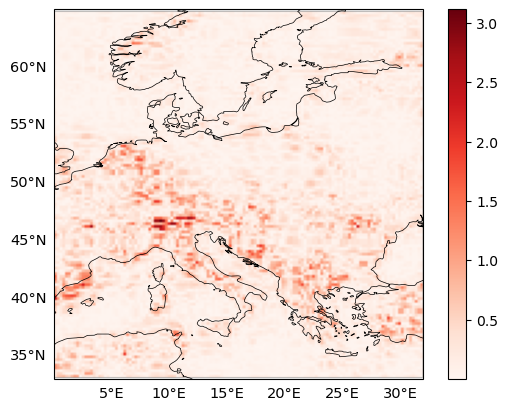

In [ ]:
proj_data = ccrs.PlateCarree()
proj_plot = ccrs.PlateCarree(central_longitude=180)

fig, axs = plt.subplots(subplot_kw={'projection': proj_plot})
#fig.set_figheight(8)
#fig.set_figwidth(10)

lon_min, lon_max = 0, 32
lat_min, lat_max = 33, 65

img = abs_err_ngcd 
img_cmap = "Reds"

ax = axs
im = ax.imshow(img,
               extent=[lon_min, lon_max, lat_max, lat_min],
               origin='lower',
               transform=proj_data,
               cmap=img_cmap,
               zorder=0
               )

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj_data)

# overlays
ax.coastlines(linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.MultipleLocator(5)
gl.ylocator = mticker.MultipleLocator(5)
gl.xlabel_style = {'size': 10.5}
gl.ylabel_style = {'size': 10.5}

ax.set(xlabel="longitude")
ax.set(ylabel="latitude")

fig.colorbar(im, ax=ax)

plt.show()


In [ ]:
# TODO: metrics here (working code already in src/evaluation.py)